<a href="https://colab.research.google.com/github/marvin-hansen/fastai/blob/master/Lesson_5_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 5: Back propagation; Accelerated SGD; Neural net from scratch 

https://course.fast.ai/videos/?lesson=5

https://github.com/hiromis/notes/blob/master/Lesson5.md


In lesson 5 we put all the pieces of training together to understand exactly what is going on when we talk about back propagation. We'll use this knowledge to create and train a simple neural network from scratch.

We'll also see how we can look inside the weights of an embedding layer, to find out what our model has learned about our categorical variables. This will let us get some insights into which movies we should probably avoid at all costs…

Although embeddings are most widely known in the context of word embeddings for NLP, they are at least as important for categorical variables in general, such as for tabular data or collaborative filtering. They can even be used with non-neural models with great success.



# Notes

Fine tune nets 

Transfer learning with Res-34 

Image net comes with 1000 category columns 
CreateCNN deletes that matrix and creates two empty matrrixes 

The fast.ai learner then trains just these two layers while keeping previous layers. 
The previous layers are good at finding specific layers. The higher layers, however, become more specific and detailed. 
Thus, early layers can be preserved. --> freeze 

Freeze means don't back-propagete into the early layers and only update the new layers.
Doesn't change existing layers. 

Unfreeze

means that all layers gets new training. However, the earliest layer needs the least learning, the mid, perhaps a bit more, and only the newest layer gets the highest learning rate. Thus, fast.ai uses discrimative learning to do just that. 

Learning rate fine-tuning. 

fit(epoch, LR)

epoch - a look at each element of the dataset
* too high (>10) - overfit
* too low - underfit 

LR can be: 
* 1e3 -same learning rate for all layers - no discriminative learning  
* slice(1e-3) - Final layer gets that number (1e-3)  and all others get LR/3
* slice(1e-5, 1e-3) - The final (newest) layer still gets (1e-3) while the first layer gets (1e-5,) and all the other layers gets rate that are multiplicateive equal across the number of layers. Layers are grouped and each group gets a different LR. 


Colab filtering have only one layer (group) so only one learning rate can be passed.   


weigth decay (wd) 
* Type of regularization 
* Models with more parametters tend to overfit in traditional  statistics
* Mostly limits complexity 
* In deep learning, however, more parameters is usually better
* Add sum of all squres of parameters to loss function
* To regularize parameters, multiply with a constant wd
* wd = 0.1  or 0.01 (default) 

weigth decay subtractsa constant from the weights at each epoch, thus making weights smaller, thus decay.

## Install 

In [0]:
!pip install imgaug==0.2.7

!pip install = folium==0.2.1

!pip install --upgrade pandas

!pip install --upgrade numpy

#!pip install --upgrade fastai

!curl -s https://course.fast.ai/setup/colab | bash

In [20]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


## Constants & global flags

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#batch size 

bs = 64
# bs = 32 
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Import Fast.ai & PyTorch


In [3]:
import fastai
from fastai import *
from fastai.basics import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.collab import *
from fastai.tabular import *

import matplotlib.pyplot as plt
from PIL import Image

print("FastAI Version: " + str(fastai.__version__))

FastAI Version: 1.0.51


In [4]:
import torch

print("PyTorch Version: " + str(torch.__version__))

PyTorch Version: 1.0.1.post2


## Check GPU *acceleration*

In [5]:
torch.cuda.current_device()
print("Cuda available: " + str(torch.cuda.is_available()))
print("Cuda enabled:" + str(torch.backends.cudnn.enabled))
#https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
#Additional Info when using cuda
if device.type == 'cuda':
    print("GPU used: " + torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Cuda available: True
Cuda enabled:True
Using device: cuda

GPU used: Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# MNIST SGD¶



In [0]:
! wget http://deeplearning.net/data/mnist/mnist.pkl.gz -P data 
#! gunzip -k mnist.pkl.gz

In [22]:
!ls data

mnist.pkl.gz


In [25]:
!pwd

'/content'

In [23]:
path = Config().data_path()/''
path.ls()

[]

In [0]:
path = '/content/data/'

In [0]:
with gzip.open(path+'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

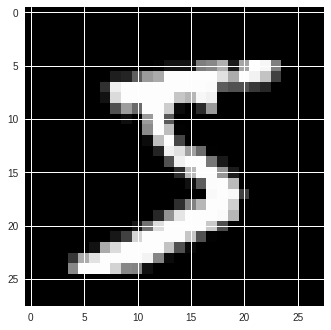

In [30]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [31]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:




```
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```



Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class Mnist_Logistic(nn.Module):
  """
  logistic regression model - nn with just one layer 
  """
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [0]:
model = Mnist_Logistic().cuda()

In [37]:
model # show all the layers 

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [38]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [39]:
[p.shape for p in model.parameters()] # show parameters 

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr=2e-2
loss_func = nn.CrossEntropyLoss()

In [0]:
def update(x,y,lr):
    """
    implements weight decay 
    """
    wd = 1e-5 #  # weight decay
    y_hat = model(x) # call model 
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd # call loss function and adds square sum and  # weight decay
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

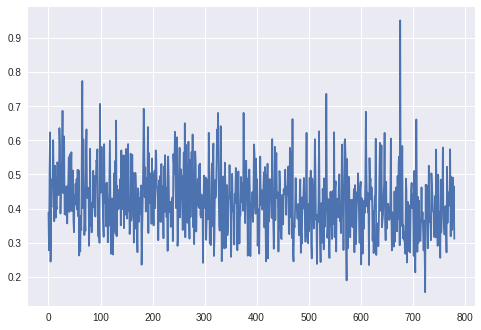

In [49]:
plt.plot(losses);

In [0]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        # output from previous layer must match input of the next one. (50)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]


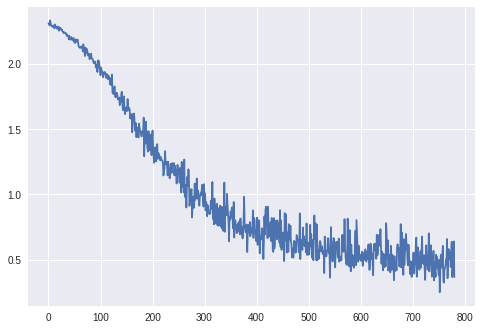

In [54]:
plt.plot(losses);

In [0]:
model = Mnist_NN().cuda() # Create a new model each time you change lr or optimzier 

In [0]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

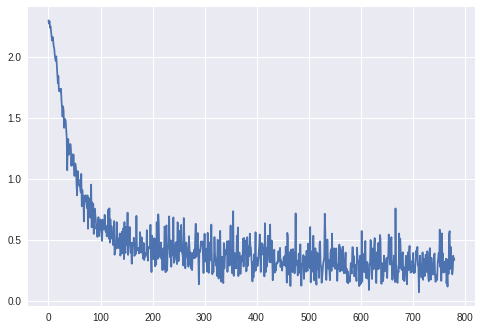

In [82]:
plt.plot(losses);

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


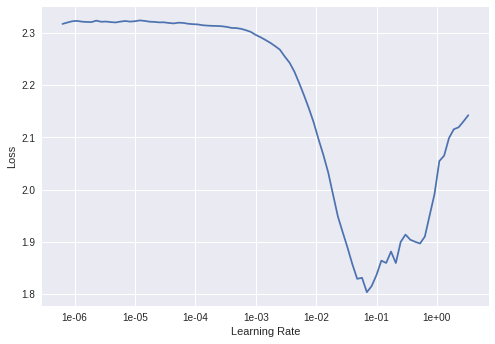

In [107]:
learn.lr_find()
learn.recorder.plot()

In [108]:
lr = slice(1e-2)
ep = 10
learn.fit_one_cycle(ep, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.274329,0.243624,0.931600,00:05
1,0.187038,0.148054,0.959000,00:05
2,0.152324,0.162743,0.952100,00:05
3,0.134753,0.143281,0.961600,00:05
4,0.112021,0.149855,0.963000,00:05
5,0.091398,0.120556,0.968100,00:05
6,0.057216,0.110869,0.971400,00:05
7,0.026260,0.101225,0.975300,00:05
8,0.021889,0.094377,0.977900,00:05
9,0.012123,0.094301,0.978800,00:05


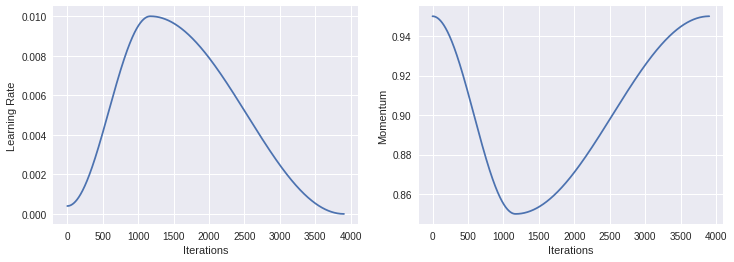

In [92]:
learn.recorder.plot_lr(show_moms=True)


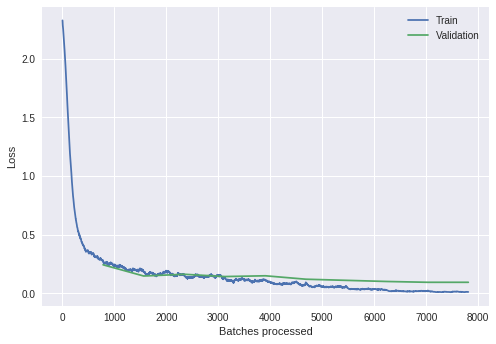

In [109]:
learn.recorder.plot_losses()